In [29]:
import pandas as pd
import re
from typing import Dict,Tuple
import matplotlib.pyplot as plt
import numpy as np

In [30]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Fetching and Processing

In [32]:
def read_excel_sheets(excel_path: str) -> Dict[str, pd.DataFrame]:
    """Read all sheets from an Excel file into a dictionary of DataFrames."""
    try:
        excel_file = pd.ExcelFile(excel_path)
        sheet_names = excel_file.sheet_names
        dataframes = {sheet: excel_file.parse(sheet) for sheet in sheet_names}
        return dataframes
    except Exception as e:
        print(f"Failed to read excel file: {e}")
        return {}

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Clean column names by ensuring the 'Date' column is properly named and reordering columns."""
    if df.iloc[0, 0] == "Date":
        df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    columns = [col for col in df.columns if "Unnamed" not in col]
    columns.remove('Dollar')
    columns.append('Dollar')
    return df[columns]

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the dataframe by dropping NA columns, filling missing values, and cleaning data."""
    df = df.iloc[1:]  # Remove the first row which may contain incorrect headers
    df = df.dropna(axis=1, how='all')
    df = df.fillna(0)
    df = clean_data(df)
    df.sort_values(by=['Date'], inplace=True)
    return df

def convert_monetary_values(x):
    """Convert monetary values from strings to floats with M and K multipliers, handles non-string types."""
    if isinstance(x, str):
        if 'M' in x:
            return float(x.replace('M', '')) * 1e6
        elif 'K' in x:
            return float(x.replace('K', '')) * 1e3
        return float(x)
    return x

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and convert data types in the dataframe."""
    for column in df.columns:
        if column == "Date":
            df[column] = df[column].apply(lambda x: re.sub(r'\-\> ', '', x) if isinstance(x, str) else x)
            df[column] = pd.to_datetime(df[column], errors='coerce')
        else:
            # Ensuring the column is treated as a string only if it's actually a string type
            if df[column].dtype == object:
                df[column] = df[column].apply(lambda x: re.sub(r'\$|\,', '', x) if isinstance(x, str) else x)
                df[column] = df[column].apply(convert_monetary_values)
            df[column] = df[column].astype(float)  # Convert to float for uniformity in numeric processing
    return df

##Returns - Closing Prices

In [33]:
# def add_total_pv_column(df: pd.DataFrame) -> pd.DataFrame:
#     """Adds a 'Tot_PV' column to the DataFrame which is the sum of all but the first column."""
#     df['Tot_PV'] = df.iloc[:, 1:].sum(axis=1)
#     return df

# def preprocess_transaction_data(df: pd.DataFrame) -> pd.DataFrame:
#     """Preprocesses transaction data by converting date strings to datetime objects and extracting the date."""
#     df['executedAt (UTC)'] = pd.to_datetime(df['executedAt (UTC)'])
#     df['Date'] = df['executedAt (UTC)'].dt.date
#     df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#     return df

# def merge_dataframes(crypto_df: pd.DataFrame, transaction_df: pd.DataFrame) -> pd.DataFrame:
#     """Merges two dataframes on the 'Date' column and simplifies transaction columns."""
#     merged_df = pd.merge(crypto_df, transaction_df[['Date', 'inflow amount', 'outflow amount']], on="Date", how="left")

#     #print(merged_df.loc[merged_df['outflow amount'].notna()])
#     #print(merged_df.isna().sum(),len(merged_df))
#     # Extract and rename the inflow and outflow amounts
#     merged_df.rename(columns={'inflow amount': 'Inflow', 'outflow amount': 'Outflow'}, inplace=True)

#     # Drop the old amount columns if needed
#     merged_df.drop(columns=['inflow amount', 'outflow amount'], errors='ignore', inplace=True)

#     # Fill NaN values with zero for the new columns
#     merged_df[['Inflow', 'Outflow']] = merged_df[['Inflow', 'Outflow']].fillna(0)

#     return merged_df

# def Combining_sheets(crypto_dataframe: pd.DataFrame, transaction_dataframe: pd.DataFrame) -> pd.DataFrame:
#     """Main function to process and merge cryptocurrency position and transaction data."""
#     try:
#         #crypto_df = add_total_pv_column(crypto_dataframe)
#         transaction_df = preprocess_transaction_data(transaction_dataframe)

#         # Merge dataframes
#         merged_df = merge_dataframes(crypto_dataframe, transaction_dataframe)

#         return merged_df

#     except Exception as e:
#         print(f"An error occurred: {e}")

In [34]:
import pandas as pd

def add_total_pv_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Objective: Adds a 'Tot_PV' column to the DataFrame which sums up all Balance except the first one.
    Args: df(pd.DataFrame): The DataFrame to process.
    Returns: pd.DataFrame: Updated DataFrame with the new 'Tot_PV' column.
    """
    df['Tot_PV'] = df.iloc[:, 1:].sum(axis=1)
    return df

def preprocess_transaction_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Objective: Converts date strings in the 'executedAt (UTC)' column to datetime objects and extracts the date component.
    Args: df (pd.DataFrame): DataFrame containing transaction data.
    Returns: pd.DataFrame: The processed DataFrame with a new 'Date' column.
    """
    df['executedAt (UTC)'] = pd.to_datetime(df['executedAt (UTC)'])
    df['Date'] = df['executedAt (UTC)'].dt.date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    return df

def merge_dataframes(crypto_df: pd.DataFrame, transaction_df: pd.DataFrame) -> pd.DataFrame:
    """
    Objective: Merges two DataFrames on the 'Date' column and refines transaction data.

    Args:   crypto_df (pd.DataFrame): DataFrame with Cryptocurrency Positional History.
            transaction_df (pd.DataFrame): DataFrame with transaction data like Inflow and Outflow
    Returns:
    pd.DataFrame: Merged DataFrame with essential transaction columns.
    """
    # Mege the datasets based on data for the required columns
    merged_df = pd.merge(crypto_df, transaction_df[['Date', 'inflow amount', 'outflow amount']], on="Date", how="left")

    # Extract and rename the inflow and outflow amounts
    merged_df.rename(columns={'inflow amount': 'Inflow', 'outflow amount': 'Outflow'}, inplace=True) #Rename Columns

    # Drop the old amount columns if needed
    merged_df.drop(columns=['inflow amount', 'outflow amount'], errors='ignore', inplace=True)

    # Fill NaN values with zero for the new columns
    merged_df[['Inflow', 'Outflow']] = merged_df[['Inflow', 'Outflow']].fillna(0)

    return merged_df

def Combining_sheets(crypto_dataframe: pd.DataFrame, transaction_dataframe: pd.DataFrame) -> pd.DataFrame:
    """Main function to process and merge cryptocurrency position and transaction data."""
    try:
        #crypto_df = add_total_pv_column(crypto_dataframe)
        transaction_df = preprocess_transaction_data(transaction_dataframe)

        # Merge dataframes
        merged_df = merge_dataframes(crypto_dataframe, transaction_dataframe)

        return merged_df

    except Exception as e:
        print(f"An error occurred: {e}")

def calculate_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Objective: Calculate daily percentage change for 'Tot_PV' and adjust for inflows and outflows to provide adjusted returns.
    Args:  df(pd.DataFrame): DataFrame with total portfolio values and transactions.
    Returns: pd.DataFrame: DataFrame with additional columns for returns and adjusted returns.
    """
    df1['Tot_return'] = df1['Tot_PV'].pct_change() * 100
    df1['Opening'] = df1['Tot_PV'].shift(1)
    df1['Closing'] = df1['Tot_PV'] - df1['Inflow'] + df1['Outflow']
    df1['Adj_returns'] = ((df1['Closing'] / df1['Opening']) - 1) * 100
    df1 = df1.fillna(0)
    return df1

def calculate_column_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate returns for all columns except 'Date'.
    Args: df(pd.DataFrame): The DataFrame to process.
    Returns: pd.DataFrame: New DataFrame with percentage changes for each column.
    """
    df2 = pd.DataFrame(df['Date'])
    for column in df.columns:
        if column != 'Date' and column !='Tot_PV' and column != 'Dollars':
            df2[column] = df[column].pct_change()
    df2.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    df2 = df2.fillna(0)
    return df2

def normalize_weights(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize weights of asset columns by dividing each by 'Tot_PV'.
    Args: df (pd.DataFrame): DataFrame with assets and their values.
    Returns: pd.DataFrame: Adjusted DataFrame with normalized weights for assets.
    """
    cols_to_normalize = [col for col in df.columns if col not in ["Date", "Tot_PV","Dollars" ,"Inflow", "Outflow"]]
    for col in cols_to_normalize:
        df[col] = (df[col] / df["Tot_PV"])
    df.drop(['Tot_PV'], axis=1, inplace=True)
    return df

def combine_dataframes(df_weights: pd.DataFrame, df_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Objective:  Multiply normalized weights by returns and sum them to calculate the daily portfolio return.
    Args:  df_weights (pd.DataFrame): DataFrame with asset weights.
           df_returns (pd.DataFrame): DataFrame with asset returns.
    Returns:  pd.DataFrame: Resulting DataFrame with daily portfolio returns.
    """
    df_weights.set_index('Date', inplace=True)
    df_returns.set_index('Date', inplace=True)

    df_returns = df_returns.iloc[1:]

    result_df = df_weights.mul(df_returns, axis=1)

    result_df['Daily_Portfolio_Return'] = result_df.sum(axis=1)  # Convert to percentage
    return result_df

def process_financial_data(merged_df: pd.DataFrame, crypto_df: pd.DataFrame) -> pd.DataFrame:
    """
    Objective:Process financial data to calculate adjusted returns and normalize weights.
    Args:  merged_df (pd.DataFrame): DataFrame with asset and cash inflow and outflow.
           crypto_df (pd.DataFrame): DataFrame with asset sum(Balance)
    Returns:  pd.DataFrame: Resulting DataFrame with daily portfolio returns.
    """
    try:
        #print("Method 1 to calculate Daily returns")
        tot_ret_df = calculate_returns(merged_df)

        #print("Method 2 to calculate Daily returns")
        IR_df = calculate_column_returns(crypto_df.copy()).round(5)
        weights_df = normalize_weights(crypto_df.copy()).round(5)

        result_df = combine_dataframes(weights_df.copy(), IR_df.copy())

        return result_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of errors

##Visualization

In [35]:
def plot_time_series(df: pd.DataFrame, figsize: tuple = (10, 20), marker: str = '.', linestyle: str = '-', grid: bool = True):
    """
    Plots time series data from a DataFrame for each numeric column against a specified date column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the time series data.
        date_col (str): The name of the column in df that contains the date data.
        figsize (tuple): The size of the figure (width, height) in inches.
        marker (str): The marker style for the plot points (e.g., 'o' for circle, '^' for triangle).
        linestyle (str): The line style for the plot (e.g., '-' for solid, '--' for dashed).
        grid (bool): A flag to indicate whether to display grid lines.
    """
    date_col ='Date'
    # Ensure the date column is datetime type for plotting
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col])

    # Setup plot - calculate number of subplots needed based on the number of numeric columns
    numeric_cols = df.select_dtypes(include=[ 'float64', 'int']).columns.tolist()
    if date_col in numeric_cols:
        numeric_cols.remove(date_col)

    fig, axs = plt.subplots(len(numeric_cols), 1, figsize=figsize, constrained_layout=True)

    # Plot each numeric column against the date column
    for i, column in enumerate(numeric_cols):
        ax = axs if len(numeric_cols) == 1 else axs[i]
        ax.plot(df[date_col], df[column], marker=marker, linestyle=linestyle)
        ax.set_title(f'Time Series of {column}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        if grid:
            ax.grid(True)

    plt.show()

##Daily Returns

In [36]:
# def calculate_returns(df1):
#     """Calculate daily percentage change for 'Tot_PV' and adjust for inflows and outflows."""
#     df1['Tot_return'] = df1['Tot_PV'].pct_change() * 100
#     df1['Opening'] = df1['Tot_PV'].shift(1)
#     df1['Closing'] = df1['Tot_PV'] - df1['Inflow'] + df1['Outflow']
#     df1['Adj_returns'] = ((df1['Closing'] / df1['Opening']) - 1) * 100
#     df1 = df1.fillna(0)
#     return df1

# def calculate_column_returns(df):
#     """Calculate returns for all columns except 'Date'."""
#     df2 = pd.DataFrame(df['Date'])
#     for column in df.columns:
#         if column != 'Date' and column !='Tot_PV' and column != 'Dollars':
#             df2[column] = df[column].pct_change()
#     df2.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
#     df2 = df2.fillna(0)
#     return df2

# def normalize_weights(df):
#     """Normalize asset columns by 'Tot_PV' excluding specific columns."""
#     cols_to_normalize = [col for col in df.columns if col not in ["Date", "Tot_PV","Dollars" ,"Inflow", "Outflow"]]
#     for col in cols_to_normalize:
#         df[col] = (df[col] / df["Tot_PV"])
#     df.drop(['Tot_PV'], axis=1, inplace=True)
#     return df

# def combine_dataframes(df_weights, df_returns):
#     """Multiply weights by returns and calculate daily portfolio return."""
#     df_weights.set_index('Date', inplace=True)
#     df_returns.set_index('Date', inplace=True)

#     df_returns = df_returns.iloc[1:]

#     result_df = df_weights.mul(df_returns, axis=1)
#     result_df['Daily_Portfolio_Return'] = result_df.sum(axis=1)  # Convert to percentage

#     #la = result_df[result_df['Daily_Portfolio_Return'] > 10]
#     #csv_filename = '/content/drive/MyDrive/Genie-Ara/result.xlsx'
#     #result_df.round(4).to_csv(csv_filename, index=True)
#     return result_df

# def process_financial_data(merged_df , crypto_df):
#     """Process financial data to calculate adjusted returns and normalize weights."""
#     try:
#         #print("Method 1 to calculate Daily returns")
#         tot_ret_df = calculate_returns(merged_df)

#         #print("Method 2 to calculate Daily returns")
#         IR_df = calculate_column_returns(crypto_df.copy()).round(5)
#         weights_df = normalize_weights(crypto_df.copy()).round(5)

#         result_df = combine_dataframes(weights_df.copy(), IR_df.copy())

#         return result_df

#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return pd.DataFrame()  # Return an empty DataFrame in case of errors

## Factor_Data

In [37]:
import yfinance as yf
from datetime import timedelta

def fetch_adjusted_close(tickers, start_date, end_date):
    """
    Fetches adjusted close prices for specified tickers within a date range.

    Parameters:
        tickers (list of str): List of ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices for given tickers.
    """
    start_date = pd.to_datetime(start_date) - timedelta(days=1)
    end_date = pd.to_datetime(end_date) + timedelta(days=1)

    data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

    if 'Adj Close' in data.columns.levels[0]:
        adj_close_prices = data['Adj Close']
    else:
        adj_close_prices = data
    adj_close_prices.reset_index(inplace=True)

    return adj_close_prices

def calculate_returns(df):
    """
    Calculates percentage changes in prices from one day to the next across specified columns.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'Date' column and one or more price columns.

    Returns:
        pd.DataFrame: DataFrame containing the date and percentage changes.
    """
    df2 = pd.DataFrame(df['Date'])
    for column in df.columns:
        if column != 'Date':
            df2[column] = df[column].pct_change()*100
    df2.dropna(inplace=True)  # Removing the first row that always contains NaN due to pct_change
    return df2

def Factor_download(tickers, start_date, end_date):
  # Initialize variables
  factor_prices = fetch_adjusted_close(tickers, start_date, end_date)

  # Filling missing data
  factor_prices['^GSPC'].ffill(inplace=True)
  factor_prices['^GSPC'].bfill(inplace=True)

  factor_prices.reset_index(drop=True, inplace=True)

  # Calculating returns
  factor_returns = calculate_returns(factor_prices)

  return factor_returns

def Factor_Data(tickers, crypto_df, result_df):

  factor_DDF = Factor_download(tickers, crypto_df['Date'].min().strftime('%Y-%m-%d'), crypto_df['Date'].max().strftime('%Y-%m-%d'))
  # Merging DataFrames
  if 'Date' not in factor_DDF.columns:
      factor_DDF.reset_index(inplace=True)

  if 'Date' not in result_df.columns:
      result_df.reset_index(inplace=True)
  selected_columns = ['Date'] + tickers

  factor_table = pd.merge(factor_DDF[selected_columns], result_df[['Date', 'Daily_Portfolio_Return']], on='Date', how='left')
  return factor_table

##Risk vs Returns

In [38]:
def Risk_vs_Return(df):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    daily_mean_returns = df[numeric_cols].mean()
    n=len(df)
    #print(df.mean())
    Average_return = daily_mean_returns * n
    print("\nAverage Returns")
    print(Average_return.sort_values())

    Standard_Deviation = df[numeric_cols].std() * np.sqrt(n)
    print("\nStandard_Deviation")
    print(Standard_Deviation.sort_values())

    risk_free_rate=0
    Sharpe_R = Average_return / Standard_Deviation
    print("\nSharpe_Ratio \n")
    print(Sharpe_R.sort_values(),"\n")

    # Assuming 'Sharpe_R' is a DataFrame with the Sharpe Ratios
    Sharpe_R.plot.bar(
        title="Sharpe Ratio",
        grid=True,
        figsize=(12,5),
        rot=0,
        ylabel="Sharpe Ratio"
    )
    plt.show()  # This ensures that the plot is shown and then the plotting area is cleared

    print("\n\n")  # Just adding space between the plots for clarity

    # Assuming 'df' is your DataFrame of daily returns
    df.plot(
        kind='box',
        figsize=(12,5),
        title="Box Plot of Funds' Daily Returns",
        ylabel="Returns [%]"
    )
    plt.show()  # This will show the second plot separately



##Factor Analysis

In [39]:
from IPython.display import display

def Covariance_Analysis(df):
  df['Date'] = pd.to_datetime(df['Date'])

  # Setting Date as the index
  df.set_index('Date', inplace=True)

  # Calculate daily returns for BTC, ETH, and ^GSPC
  #df[['BTC_Returns', 'ETH_Returns', 'GSPC_Returns']] = df[['BTC-USD', 'ETH-USD', '^GSPC']].pct_change()

  # Compute covariance matrix between the returns of BTC, ETH, ^GSPC, and the portfolio returns
  covariance_matrix = df.cov()

  # Print the covariance matrix
  print(covariance_matrix,"\n\n")

def Permutation_Importance(df):
  X = df.iloc[:,1:-1]
  y = df.iloc[:,-1]

  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train a linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test)

  # Calculate R2 Score to evaluate
  r2 = r2_score(y_test, y_pred)
  print(f'R2 Score: {r2}')

  # Compute permutation importance
  perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)


  # Display the importance of each feature with additional context
  for i in perm_importance.importances_mean.argsort()[::-1]:
      significant = perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0
      print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.3f} +/- {perm_importance.importances_std[i]:.3f}"
            f" - {'Significant' if significant else 'Not Significant'}")

  print("\n\n")

def Shap_Importance(data):
    # Initialize JavaScript visualization in the notebook
    shap.initjs()

    # Prepare the data
    #X = data[['BTC-USD', 'ETH-USD', '^GSPC']]  # Features
    #y = data['Daily_Portfolio_Return']

    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]


    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = xgb.XGBRegressor(objective ='reg:squarederror', booster='gbtree', n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # Visualize the first prediction's explanation using force_plot
    plot = shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], show=False)
    display(plot)  # Display the force plot

    # Visualize the overall feature importance using summary_plot
    plt.figure()
    shap.summary_plot(shap_values, X_train)
    plt.show()  # Ensure this plot is shown in the notebook

    # Visualize the dependence plot for a specific feature
    plt.figure()
    shap.dependence_plot(X.columns[1], shap_values, X_train)
    plt.show()  # Ensure this plot is shown


In [40]:
!pip install shap

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap

def Factor_Analysis(df):
    Covariance_Analysis(df)
    Permutation_Importance(df)
    Shap_Importance(df)

#Main

[*********************100%%**********************]  3 of 3 completed



Average Return
OCEAN/USDT:USDT          -0.051098
BADGER/USDT:USDT         -0.046681
Frax Share                0.000000
Maker                     0.000000
RPL/USDT:USDT             0.424752
Render                    0.431673
Ribbon Finance            0.909183
Dollar                    1.825098
Daily_Portfolio_Return    3.452779
dtype: float64

Standard_Deviation
Frax Share                0.000000
Maker                     0.000000
OCEAN/USDT:USDT           0.020957
BADGER/USDT:USDT          0.034374
RPL/USDT:USDT             0.308790
Render                    0.345918
Ribbon Finance            0.414325
Dollar                    1.813641
Daily_Portfolio_Return    1.891900
dtype: float64

Sharpe_Ratio 

OCEAN/USDT:USDT          -2.438256
BADGER/USDT:USDT         -1.358010
Dollar                    1.006317
Render                    1.247906
RPL/USDT:USDT             1.375535
Daily_Portfolio_Return    1.825032
Ribbon Finance            2.194371
Frax Share                     NaN
Maker   

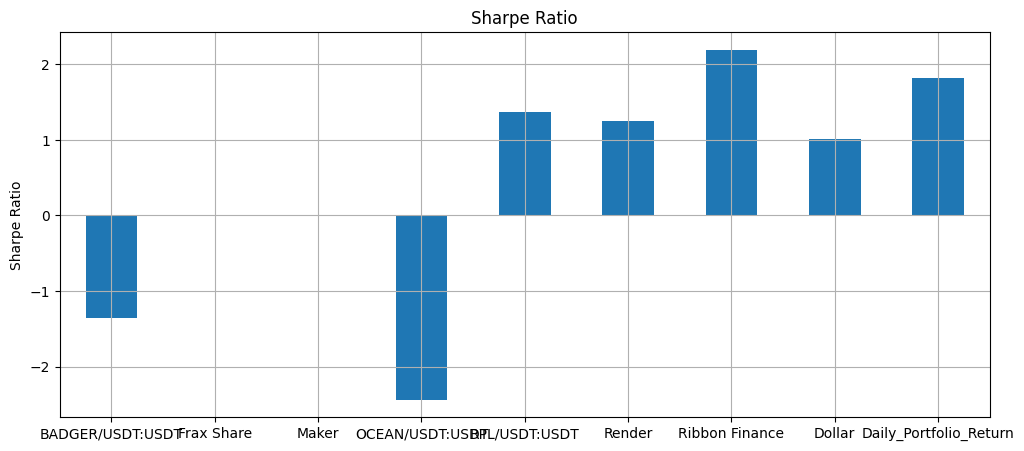

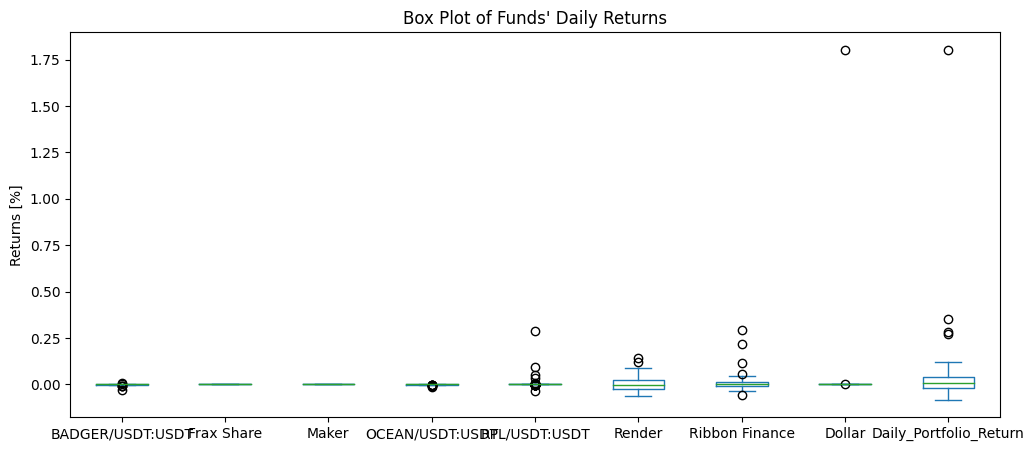

                          BTC-USD     ^GSPC    ETH-USD  Daily_Portfolio_Return
BTC-USD                 10.411535  0.244328   8.563749                0.093927
^GSPC                    0.244328  0.332733   0.350559                0.020566
ETH-USD                  8.563749  0.350559  10.896273                0.124576
Daily_Portfolio_Return   0.093927  0.020566   0.124576                0.041141 


R2 Score: 0.027515275553066987
ETH-USD: 0.289 +/- 0.234 - Not Significant
^GSPC: 0.018 +/- 0.141 - Not Significant





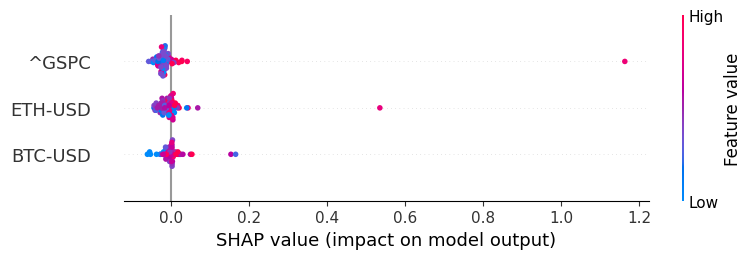

<Figure size 640x480 with 0 Axes>

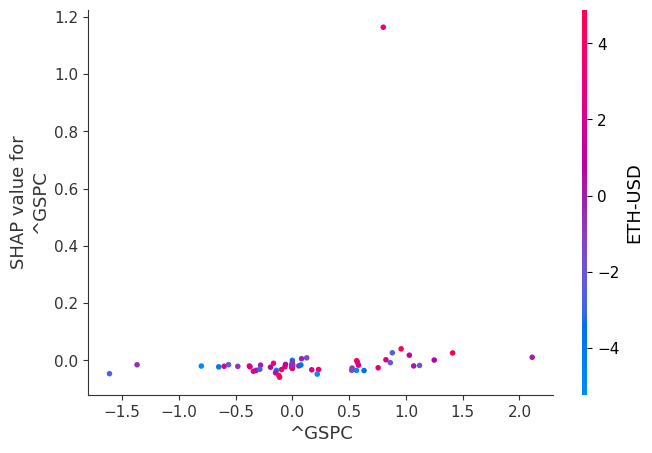

In [42]:
def main():

    file_path = '/content/drive/MyDrive/Genie-Ara/Quant Dev Home Assignment Dataset.xlsx'


    dataframes = read_excel_sheets(file_path)

    if 'position history' in dataframes:
      crypto_df = dataframes['position history'].copy()
      crypto_df = clean_column_names(crypto_df)
      crypto_df = preprocess_dataframe(crypto_df)

    crypto_df_working = add_total_pv_column(crypto_df)

    if 'transaction history' in dataframes:
      transaction_df = dataframes['transaction history'].copy()
      complete_df = Combining_sheets(crypto_df_working,transaction_df)

    result_df = process_financial_data(complete_df, crypto_df)

    factor_df = Factor_Data(['BTC-USD','^GSPC','ETH-USD'], crypto_df, result_df)

    Risk_vs_Return(result_df)

    Factor_Analysis(factor_df)

if __name__ == "__main__":
    main()